# Installs and Imports

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.4/898.4 kB 24.6 MB/s eta 0:00:00


In [2]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 39.9 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [3]:
# YOLOv9 was used for the project, so we installed and imported Ultralytics YOLO

import ultralytics
from ultralytics import YOLO
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import random
import yaml
import matplotlib.pyplot as plt
import albumentations as A
import cv2
import shutil
import glob
import subprocess
from IPython.display import HTML
from base64 import b64encode

%matplotlib inline

# Check the version of ultralytics
print(ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
8.3.43


# Dataset Imports and EDA

In [4]:
# Load the dataset into Google Drive and mount the drive. Easier for repeated reconnections of colab to a compute resource

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Validation

For this project, we are using Apply Grayscale to start with. The Kaggle website says that grayscale has been applied to the images but most of the images still appear to be color.

Let's validate and ensure the labels don't have anything abnormal

In [5]:
# Validate labels to see if they all are in the right format that YOLO expects, and check if the values of labels are in range of the label vector length
def validate_label_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line_num, line in enumerate(lines, start=1):
            parts = line.strip().split()
            if len(parts) != 5:
                print(f"Incorrect format in {file_path}, line {line_num}: {line.strip()}")
                return False
            try:
                class_id = int(parts[0])  # Class ID must be an integer
                bbox = [float(x) for x in parts[1:]] # Bounding boxes or BBOX should be floats as they are normalized
                if not all(0 <= x <= 1 for x in bbox):  # Confirm normalization of boxes
                    print(f"Out-of-range values in {file_path}, line {line_num}: {line.strip()}")
                    return False
            except ValueError:
                print(f"Non-numeric value in {file_path}, line {line_num}: {line.strip()}")
                return False
    return True

# Loop through all label files in train, test, and validation folders
folders = [
    '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/labels',
    '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/test/labels',
    '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/valid/labels'
]

all_valid = True
for labels_folder in folders:
    for file_name in os.listdir(labels_folder):
        if file_name.endswith('.txt'):
            file_path = os.path.join(labels_folder, file_name)
            if not validate_label_file(file_path):
                all_valid = False

if all_valid:
    print("All incoming data looks good.")


All incoming data looks good.


## Exploratory Data Analysis

As we see above, the labels have been normalized already and things look good overall. We can start using the data, and we will start with some explorations on how many instances of each class type exist, and how balanced the classes are.

Total Instances (All Images Combined):
Truck: 64
Car: 2023
Motorcycle: 355
Pickup: 251
Bus: 31

Number of Images Containing Each Class:
Car: 123
Truck: 46
Motorcycle: 74
Pickup: 91
Bus: 28


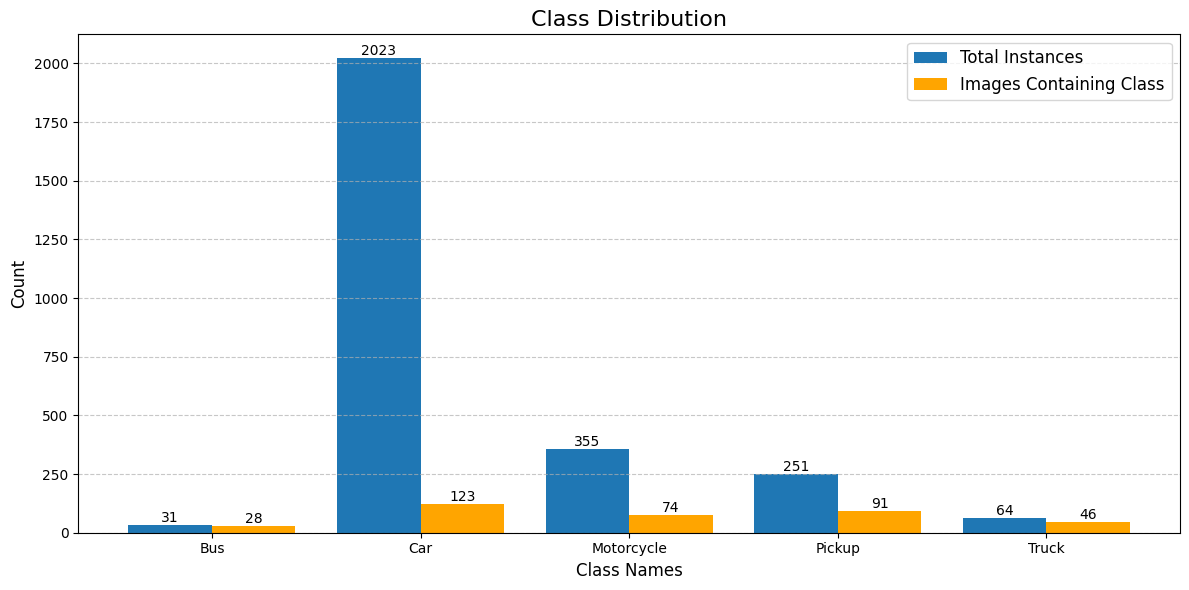

In [6]:
# same labels folder as above, copying it into this cell for easy reference
labels_folder = '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/labels'

# Initialize counters
class_instance_counts = Counter()
class_image_counts = Counter()

# loop through all the labels
for file_name in os.listdir(labels_folder):
    if file_name.endswith('.txt'):
        file_path = os.path.join(labels_folder, file_name)
        image_classes = set()  # Use set to track unique classes in this image
        with open(file_path, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])  # Extract the class ID (first column)
                class_instance_counts[class_id] += 1  # Count total instances
                image_classes.add(class_id)  # Add to set of classes in this image
        # Update class_image_counts for this image
        for class_id in image_classes:
            class_image_counts[class_id] += 1

# Map class IDs to class names (from the YAML file)
class_names = ['Bus', 'Car', 'Motorcycle', 'Pickup', 'Truck']
class_instance_counts_named = {class_names[class_id]: count for class_id, count in class_instance_counts.items()}
class_image_counts_named = {class_names[class_id]: count for class_id, count in class_image_counts.items()}

# Print the counts for each class
print("Total Instances (All Images Combined):")
for class_name, count in class_instance_counts_named.items():
    print(f"{class_name}: {count}")

print("\nNumber of Images Containing Each Class:")
for class_name, count in class_image_counts_named.items():
    print(f"{class_name}: {count}")

# Prepare data for visualization
x = np.arange(len(class_names))  # X-axis positions
width = 0.4  # Width of bars

# Plot side-by-side bar charts to compare total instances and number of images containing each class
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, [class_instance_counts[class_id] for class_id in range(len(class_names))],
                width=width, label='Total Instances')
bars2 = plt.bar(x + width/2, [class_image_counts[class_id] for class_id in range(len(class_names))],
                width=width, color='orange', label='Images Containing Class')

# Add titles and labels
plt.title("Class Distribution", fontsize=16)
plt.xlabel("Class Names", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(x, class_names, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Add value labels on top of bars
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()),
             ha='center', va='bottom', fontsize=10)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()),
             ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


## Large Imbalance Identified!!
We see above that cars and buses are very few (<50%) as compared to cars and even pickups. This is going to lead to poor model performance if we do not improve the dataset.

# Dynamic Augmentation Using Built-In YOLO capabilities

Dynamic augmentation refers to YOLO performing augmentation on the fly during training without the need for us to produce explicit augmented images as part of the training corpus. This is initially done by providing some augmentation hyperparameters in the YAML file

```
augmentation:
  mosaic: 1.0          # Mosaic augmentation probability  
  mixup: 0.2           # Mixup augmentation probability  
  hsv_h: 0.015         # HSV-Hue augmentation  
  hsv_s: 0.7           # HSV-Saturation augmentation  
  hsv_v: 0.4           # HSV-Value augmentation  
  flipud: 0.0          # Vertical flip probability  
  fliplr: 0.5          # Horizontal flip probability  
  scale: 0.5           # Scale probability  
  shear: 0.0           # Shear augmentation probability
```


For experimentation purposes, we opted for the "tiny" YOLOv9 model to start with just to identify where some of the challenges are. We suspect more augmentation work may be needed. We hope moving to a larger model will give us a boost in performance, so we'll try to tune hyperparameters before we go higher in model size.

In [ ]:
# Added early stopping of 15 epochs, which is ~10% of the 150 epochs runway specified.

model = YOLO('yolov9t.pt')
model.train(
    data='/content/drive/MyDrive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/data_dynamic_augmented.yaml',
    epochs=150,
    batch=32,
    verbose=True,
    augment=True,
    patience=15)

100%|██████████| 4.74M/4.74M [00:00<00:00, 83.5MB/s]


Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov9t.pt, data=/content/drive/MyDrive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/data_dynamic_augmented.yaml, epochs=150, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, 

100%|██████████| 755k/755k [00:00<00:00, 19.9MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7872  ultralytics.nn.modules.block.ELAN1           [32, 32, 32, 16]              
  3                  -1  1     18560  ultralytics.nn.modules.block.AConv           [32, 64]                      
  4                  -1  1     65216  ultralytics.nn.modules.block.RepNCSPELAN4    [64, 64, 64, 32, 3]           
  5                  -1  1     55488  ultralytics.nn.modules.block.AConv           [64, 96]                      
  6                  -1  1    145824  ultralytics.nn.modules.block.RepNCSPELAN4    [96, 96, 96, 48, 3]           
  7                  -1  1    110848  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 81.7MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/labels... 136 images, 2 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:05<00:00, 26.98it/s]

train: New cache created: /content/drive/MyDrive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/valid/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:02<00:00, 10.35it/s]

val: New cache created: /content/drive/MyDrive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      6.53G      1.477       4.26       1.11        270        640: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all         28        563    0.00146      0.124     0.0116    0.00411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      6.35G      1.421      3.991      1.043        173        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


                   all         28        563    0.00651      0.223     0.0311     0.0141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      6.61G      1.405      3.303     0.9669        230        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


                   all         28        563     0.0103       0.24     0.0541     0.0327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      6.49G       1.44       2.24     0.9605        210        640: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


                   all         28        563     0.0205      0.339      0.166     0.0789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      6.66G      1.333      1.808     0.9494        186        640: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         28        563      0.944     0.0709      0.188      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      6.48G      1.308      1.566     0.9444        228        640: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         28        563     0.0162      0.354       0.17     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      6.29G      1.258      1.453     0.9613        118        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


                   all         28        563     0.0451      0.478      0.279      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150       6.3G      1.298       1.37     0.9716        112        640: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         28        563     0.0473      0.503      0.331      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      6.92G      1.249      1.302      0.942        333        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all         28        563     0.0417      0.487      0.328        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      6.02G      1.218      1.212     0.9358        205        640: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         28        563       0.91      0.178      0.381      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      6.36G      1.218       1.21     0.9463        110        640: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         28        563      0.927      0.108      0.402      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      6.49G      1.206      1.169     0.9278        275        640: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

                   all         28        563      0.941     0.0947      0.416      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      6.08G      1.201      1.113     0.9311        318        640: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         28        563      0.928      0.134      0.421      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      6.55G      1.175      1.078     0.9266        250        640: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


                   all         28        563      0.885      0.124      0.415      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      6.88G      1.193      1.125     0.9287        283        640: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         28        563      0.846      0.201      0.464      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      6.29G      1.159      1.004     0.9178        197        640: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


                   all         28        563      0.661      0.261      0.499      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150       6.5G      1.157      1.053     0.9242        121        640: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         28        563      0.865      0.275      0.538      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      6.93G      1.127      1.012     0.9258        180        640: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         28        563      0.714      0.309      0.534      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      6.25G      1.128      0.986      0.923        146        640: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         28        563      0.708      0.314      0.516       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      6.59G       1.13      1.003      0.936        138        640: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         28        563      0.734      0.281      0.561      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      6.57G       1.14      1.012     0.9214        195        640: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

                   all         28        563      0.711      0.363      0.547      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      6.62G      1.124     0.9371     0.9079        318        640: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         28        563      0.798      0.374      0.581      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      6.51G      1.073     0.9316     0.9122        136        640: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         28        563      0.792      0.428      0.579      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      6.81G      1.119     0.9112     0.9231        156        640: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         28        563      0.787      0.412      0.605      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      6.59G      1.095     0.9645     0.9237        138        640: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


                   all         28        563      0.777      0.457       0.62       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      6.49G      1.099     0.8979     0.9225        180        640: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         28        563      0.677      0.553      0.618      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      6.36G      1.138     0.9015      0.927        204        640: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         28        563        0.7      0.625      0.637      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      6.56G       1.08     0.8797     0.9161        162        640: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         28        563      0.688       0.58      0.633      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      6.97G      1.055     0.8313     0.9155        219        640: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         28        563      0.664      0.651      0.636      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       6.7G      1.106     0.8288     0.9081        281        640: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


                   all         28        563      0.722      0.645      0.633      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      6.31G      1.037     0.8141     0.9092        149        640: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

                   all         28        563      0.662      0.635      0.621      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       6.7G      1.058     0.8472     0.8925        318        640: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         28        563      0.595      0.664      0.628      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      7.01G      1.087     0.8393     0.9102        223        640: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         28        563      0.669      0.532      0.627      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      6.79G      1.037     0.7919     0.9091        178        640: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         28        563      0.695      0.626      0.608       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      6.36G      1.035     0.7814     0.8974        222        640: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         28        563       0.71      0.558      0.617      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      6.49G      1.055     0.8058      0.907        285        640: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         28        563      0.723      0.616      0.635      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      6.78G      1.049     0.7949     0.9042        274        640: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         28        563      0.708      0.598      0.621      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      6.29G      1.002     0.8031     0.8991        147        640: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


                   all         28        563      0.761      0.668      0.679      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      6.76G      1.041     0.7768     0.8902        214        640: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         28        563      0.741       0.59      0.669      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      6.54G     0.9973     0.7719     0.9079        199        640: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

                   all         28        563      0.707        0.6      0.669      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      6.89G      1.001     0.7839      0.898        263        640: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         28        563      0.694      0.617      0.682      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      6.66G      1.036     0.7805     0.8963        163        640: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         28        563      0.786      0.606      0.691      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      6.92G      1.045     0.7616     0.8916        230        640: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         28        563       0.71      0.651      0.676      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      7.06G      1.029     0.7439     0.9081        264        640: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


                   all         28        563      0.634      0.608      0.638      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      6.54G      1.035     0.7578     0.9015        249        640: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


                   all         28        563      0.681      0.584      0.628      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      6.44G      1.032     0.7496     0.8974        172        640: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


                   all         28        563      0.721      0.624      0.666      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      7.48G      1.007     0.7523     0.8962        219        640: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

                   all         28        563       0.74      0.669      0.666      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      6.87G      1.043     0.7256     0.9005        235        640: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         28        563      0.694      0.701      0.692      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      6.74G     0.9805     0.7442     0.8878        177        640: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         28        563      0.661      0.666      0.659      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      6.83G     0.9987     0.7389     0.8929        265        640: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


                   all         28        563      0.729      0.594      0.638      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      6.46G     0.9976     0.7044      0.894        234        640: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all         28        563      0.704      0.675      0.673      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      7.31G     0.9499     0.7394     0.8888         75        640: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


                   all         28        563      0.732      0.584      0.659      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      6.55G     0.9991       0.73     0.9093        264        640: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         28        563       0.71      0.615      0.667      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150       6.7G     0.9552     0.7059     0.8887        177        640: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         28        563      0.759      0.606      0.646      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      6.51G     0.9415     0.6855     0.8912        124        640: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         28        563      0.779      0.667      0.686      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      6.87G     0.9878     0.7073     0.9022        218        640: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         28        563       0.75      0.693       0.69      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      6.78G      0.966     0.7297     0.9027        112        640: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         28        563      0.753      0.695      0.688      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      6.31G      1.004     0.7114      0.904        342        640: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         28        563       0.75      0.708      0.708      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      6.51G     0.9876     0.7013     0.9045        149        640: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

                   all         28        563      0.777      0.656      0.683      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      6.49G     0.9441     0.6797     0.8988        253        640: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

                   all         28        563      0.773      0.619      0.687      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      6.53G     0.9845     0.6876     0.8963        344        640: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         28        563      0.753      0.621       0.66      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      6.38G     0.9376     0.6585      0.878        197        640: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         28        563      0.684      0.625      0.648      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      6.23G     0.9227     0.6633     0.8892        207        640: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         28        563      0.724      0.637      0.693      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      6.69G     0.9381     0.6693     0.8824        157        640: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         28        563      0.789       0.62      0.715      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      6.87G     0.9172     0.6452     0.8926        257        640: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         28        563      0.786      0.657      0.721      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      6.33G     0.9196     0.6449     0.8895        135        640: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


                   all         28        563      0.688      0.618      0.682      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      6.43G     0.9306     0.6494     0.8748        269        640: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         28        563       0.72      0.686      0.682      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      7.12G     0.9273      0.632     0.8661        274        640: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

                   all         28        563      0.808      0.653       0.72       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      6.05G     0.9434     0.6459     0.8926        115        640: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all         28        563      0.811       0.65      0.707      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      6.47G     0.8801     0.6511     0.8909         79        640: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         28        563      0.799      0.698      0.741      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      7.16G      0.946     0.6624     0.8837        315        640: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all         28        563      0.815      0.705      0.742      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      6.27G     0.9498       0.64     0.8756        316        640: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         28        563      0.751      0.663      0.684       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      7.14G     0.9458     0.6222     0.8804        299        640: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

                   all         28        563      0.808      0.629      0.682      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      6.33G     0.9044     0.6208     0.8781        213        640: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         28        563      0.691      0.707        0.7      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      6.62G     0.9645     0.6663     0.8891        222        640: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         28        563      0.753      0.695      0.699      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      6.79G     0.9034     0.6312     0.8748        180        640: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         28        563      0.722      0.734      0.715       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      6.28G     0.8936     0.6022     0.8804        177        640: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


                   all         28        563       0.74      0.739      0.726      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      6.39G     0.9001     0.6449     0.8695        156        640: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         28        563      0.765      0.703      0.727      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      6.26G       0.95     0.6318     0.8787        244        640: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all         28        563       0.75      0.724      0.729       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      7.08G     0.9304     0.6616     0.8771        302        640: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         28        563      0.717      0.756      0.717      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      6.46G     0.9103     0.6173     0.8795        167        640: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         28        563      0.849      0.644      0.704      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      6.51G     0.9151     0.6038      0.872        253        640: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

                   all         28        563      0.815      0.588      0.734      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150       6.9G     0.8931     0.6012     0.8721        177        640: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         28        563      0.869      0.585      0.733      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       6.4G     0.9162     0.6033     0.8708        274        640: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


                   all         28        563      0.725      0.687      0.742      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      6.98G     0.8896     0.6106     0.8737        148        640: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         28        563      0.732       0.71      0.735      0.479


EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 70, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

85 epochs completed in 0.075 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 4.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 4.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv9t summary (fused): 486 layers, 1,971,759 parameters, 0 gradients, 7.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


                   all         28        563      0.765      0.673      0.732      0.482
                   Bus          6          6      0.709      0.816       0.74      0.518
                   Car         23        398       0.77       0.74      0.807       0.56
            Motorcycle         18         92      0.752      0.598      0.667      0.345
                Pickup         22         59      0.874      0.586      0.735      0.515
                 Truck          8          8      0.721      0.625       0.71      0.472
Speed: 0.2ms preprocess, 9.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e2d6e0b93f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

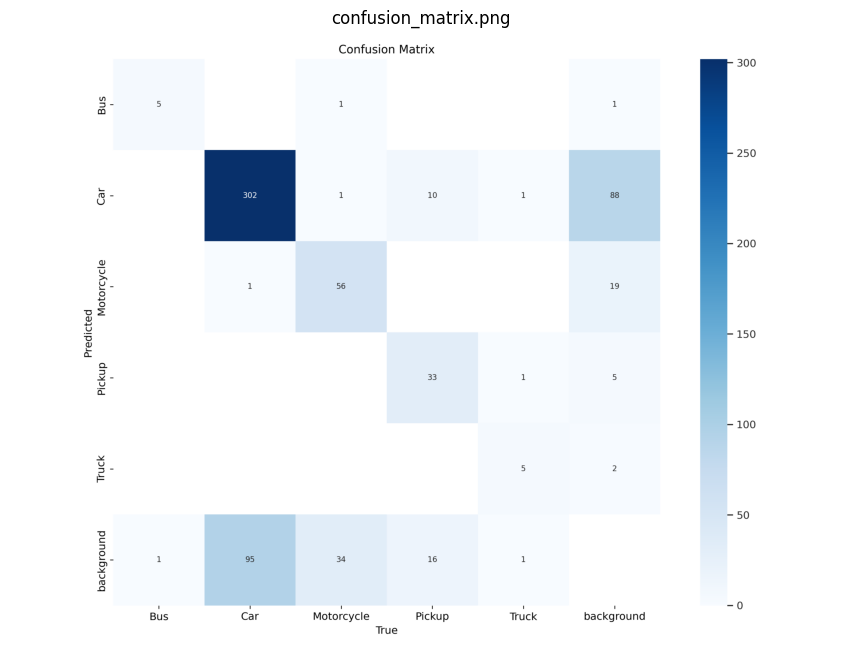

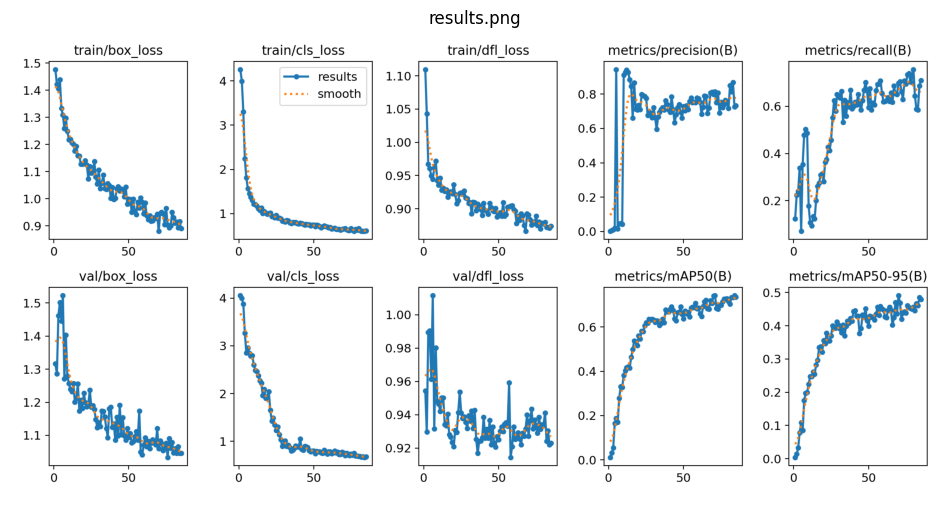

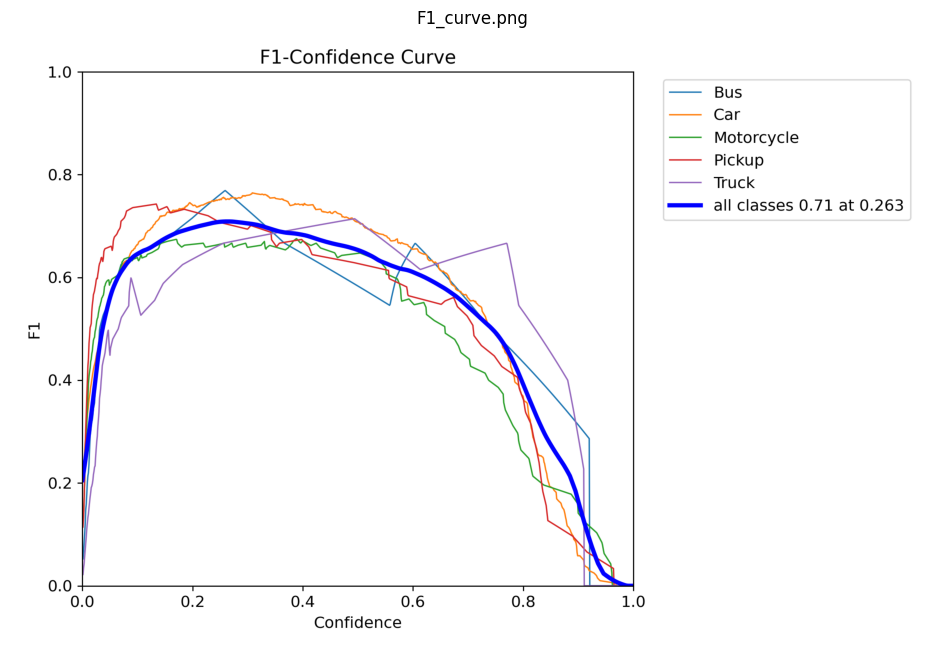

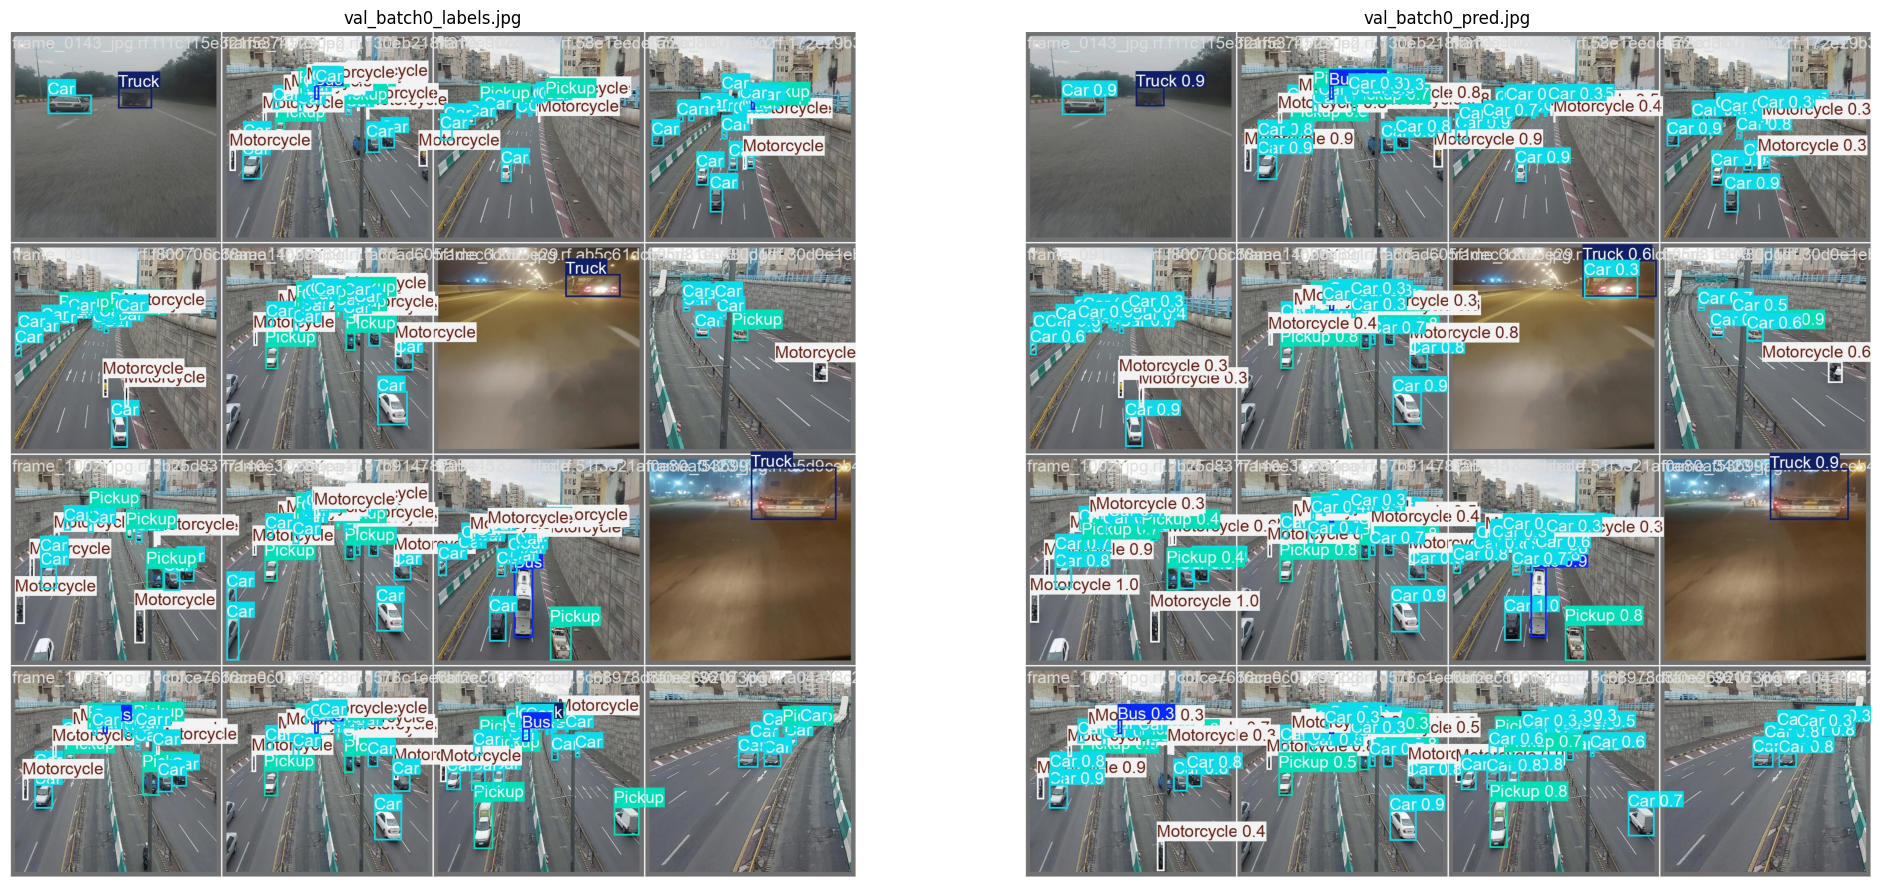

In [ ]:
runs_folder = '/content/runs/detect/'

# Find the latest train folder or all possible train folders
train_folders = [f for f in os.listdir(runs_folder) if f.startswith('train') and os.path.isdir(os.path.join(runs_folder, f))]
train_folders.sort(key=lambda x: int(x[5:]) if x[5:].isdigit() else 0)

# Use the latest train folder if multiple are present
if train_folders:
    latest_train_folder = train_folders[-1]
    train_folder = os.path.join(runs_folder, latest_train_folder)
else:
    train_folder = None

if train_folder:
    # Key image files to display
    key_images = [
        'confusion_matrix.png',
        'results.png',
        'F1_curve.png',
        'val_batch0_labels.jpg',
        'val_batch0_pred.jpg'
    ]

    # Display the first three images individually
    for img_file in key_images[:3]:
        img_path = os.path.join(train_folder, img_file)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.figure(figsize=(12, 8))
            plt.title(img_file)
            plt.imshow(img)
            plt.axis('off')  # Turn off axes for better visualization
            plt.show()

    # Display val_batch0_labels.jpg and val_batch0_pred.jpg side by side
    val_label_path = os.path.join(train_folder, key_images[3])
    val_pred_path = os.path.join(train_folder, key_images[4])

    if os.path.exists(val_label_path) and os.path.exists(val_pred_path):
        fig, axes = plt.subplots(1, 2, figsize=(24, 18))

        # Load and display val_batch0_labels.jpg
        val_label_img = Image.open(val_label_path)
        axes[0].imshow(val_label_img)
        axes[0].axis('off')
        axes[0].set_title('val_batch0_labels.jpg')

        # Load and display val_batch0_pred.jpg
        val_pred_img = Image.open(val_pred_path)
        axes[1].imshow(val_pred_img)
        axes[1].axis('off')
        axes[1].set_title('val_batch0_pred.jpg')

        plt.show()
    else:
        print("Either val_batch0_labels.jpg or val_batch0_pred.jpg is missing in the directory.")
else:
    print("No training folders found in /content/runs/detect/")


As expected, we have issues detecting pickups due to sparse data. Surprisingly buses worked ok for training/validation. Let's test this out on the test set.

In [ ]:
# Path to the directory where YOLO saves training outputs. same as above just copied for easy reference
runs_folder = '/content/runs/detect'

# Find the most recent training directory
latest_run = max([os.path.join(runs_folder, d) for d in os.listdir(runs_folder)], key=os.path.getmtime)

# Path to the best weights file
best_weights_path = os.path.join(latest_run, 'weights', 'best.pt')

# Load the model with the found best weights
model = YOLO(best_weights_path)

print(f"Loaded model from: {best_weights_path}")

metrics = model.val(
    data='/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/data_dynamic_augmented.yaml',
    split='test'
)

# Print evaluation metrics
print(metrics)

Loaded model from: /content/runs/detect/train/weights/best.pt
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv9t summary (fused): 486 layers, 1,971,759 parameters, 0 gradients, 7.6 GFLOPs


val: Scanning /content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/test/labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


                   all         13        254      0.831      0.485      0.558      0.387
                   Bus          5          5          1      0.399      0.404      0.242
                   Car         12        179      0.751      0.775       0.79       0.56
            Motorcycle          8         38      0.828      0.474      0.523      0.297
                Pickup          8         29          1      0.442      0.699      0.503
                 Truck          3          3      0.577      0.333      0.373      0.332
Speed: 0.2ms preprocess, 18.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e2dea25ac80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results

We see that bus and pickup truck have less than 0.5 MAPS-50 bounding box overlap detection success. This is unsurprising because of the very sparse data.

Let's visualize some of the outputs.

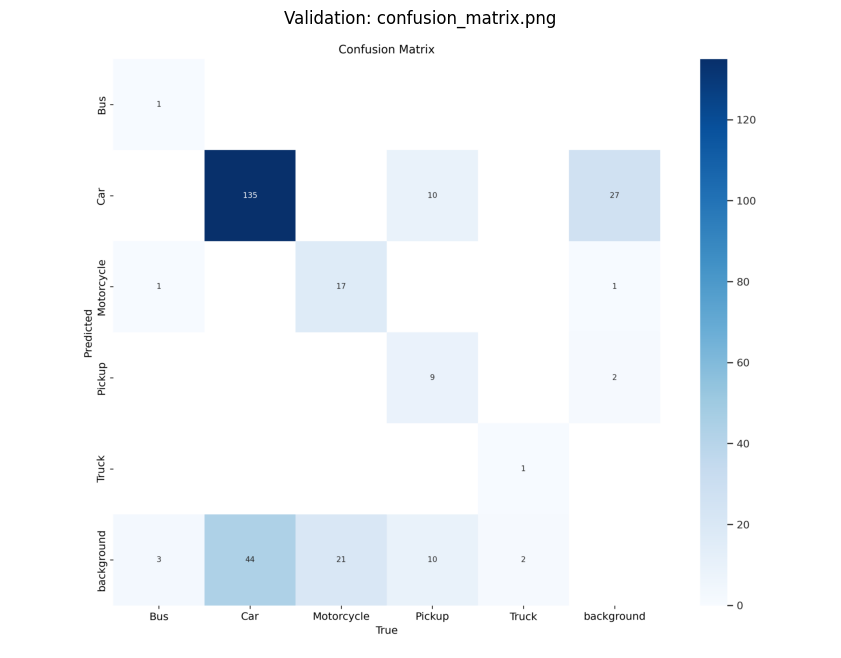

Validation: results.png not found.


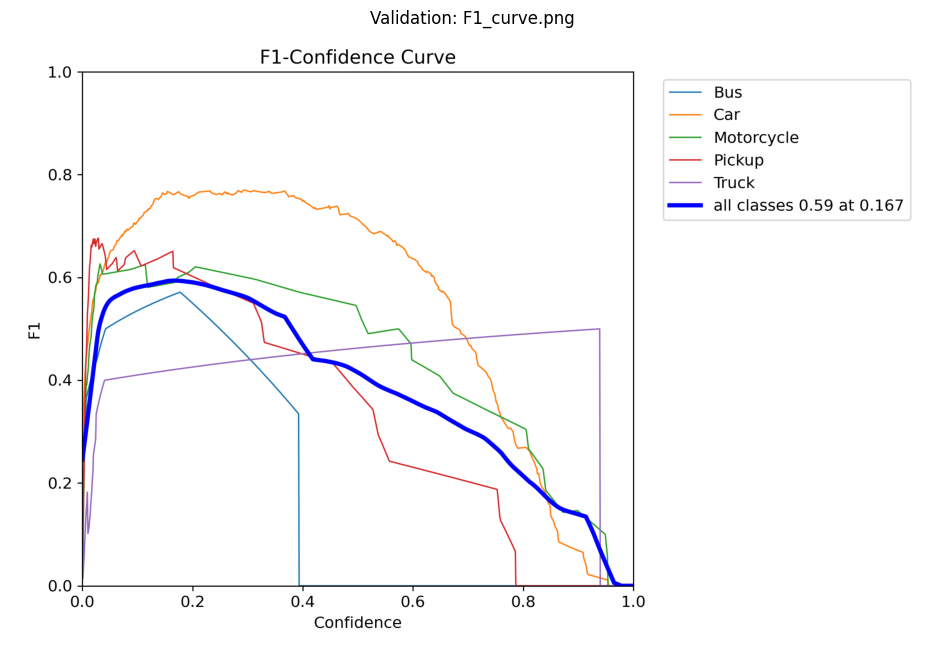

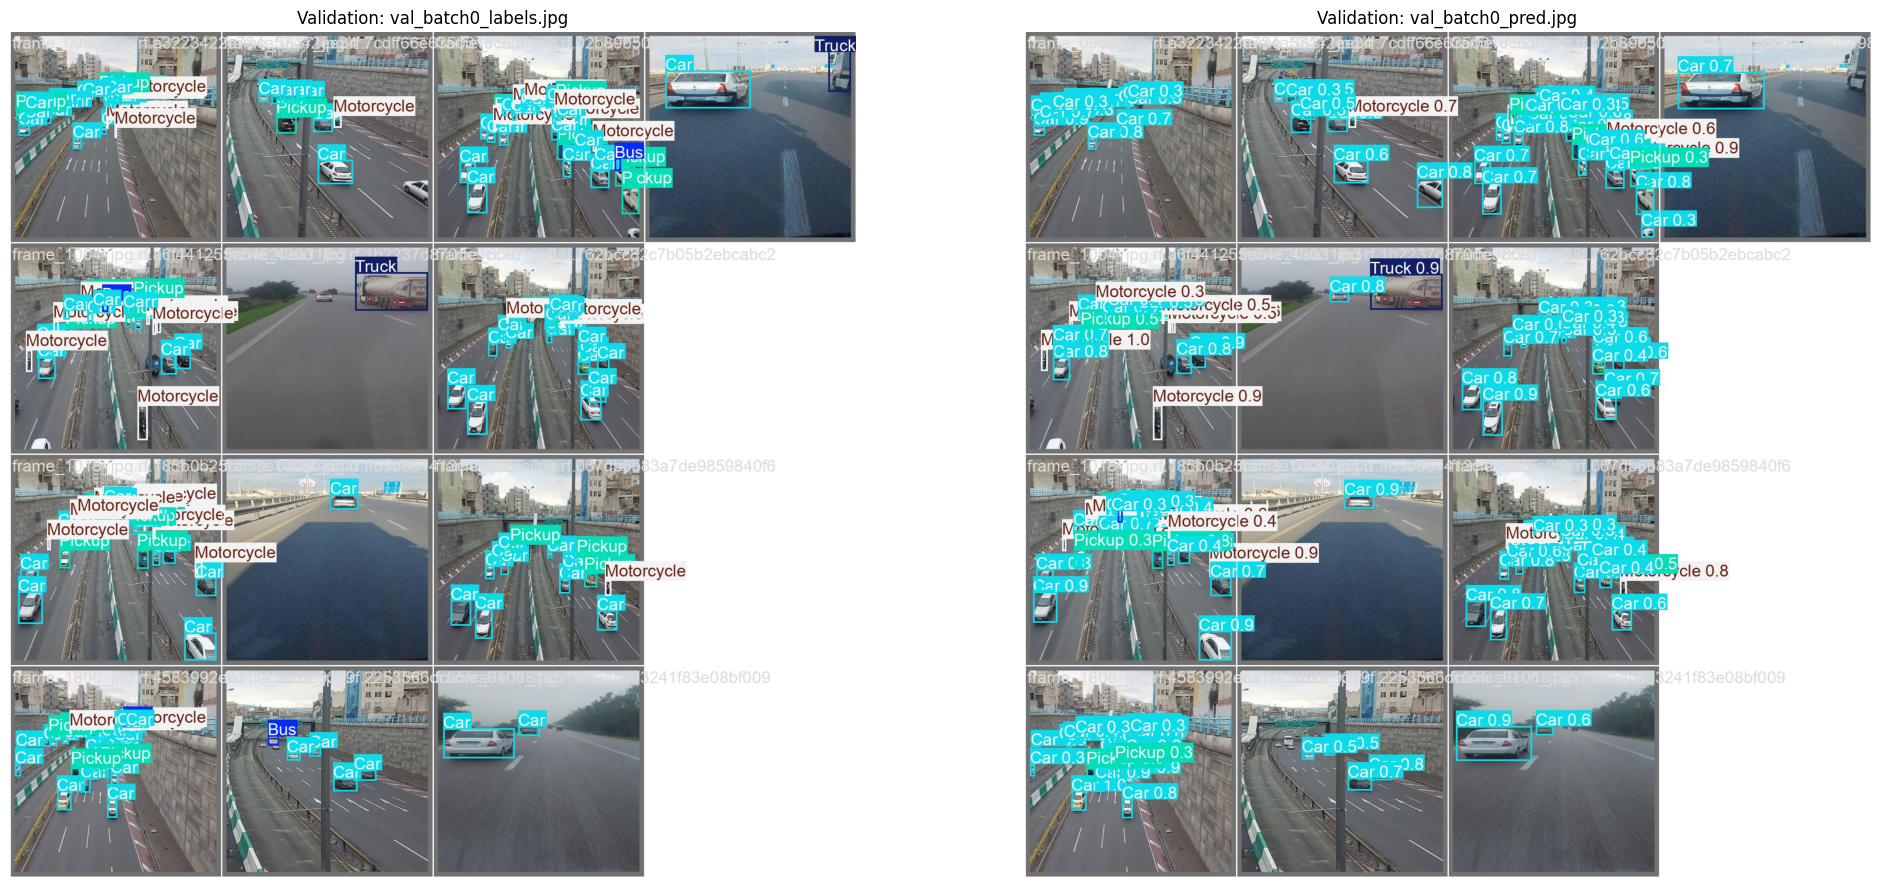

In [ ]:
runs_folder = '/content/runs/detect/'

# Find all possible validation folders
val_folders = [f for f in os.listdir(runs_folder) if f.startswith('val') and os.path.isdir(os.path.join(runs_folder, f))]
val_folders.sort(key=lambda x: int(x[3:]) if x[3:].isdigit() else 0)  # Sort by val number or default to 0 for "val"

# Use the latest validation folder if multiple are present
latest_val_folder = val_folders[-1] if val_folders else None
val_folder = os.path.join(runs_folder, latest_val_folder) if latest_val_folder else None

if val_folder:
    # Key image files to display for validation
    key_images_val = [
        'confusion_matrix.png',
        'results.png',
        'F1_curve.png',
        'val_batch0_labels.jpg',
        'val_batch0_pred.jpg'
    ]

    # Display the first three images individually for validation
    for img_file in key_images_val[:3]:
        img_path = os.path.join(val_folder, img_file)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.figure(figsize=(12, 8))
            plt.title(f"Validation: {img_file}")
            plt.imshow(img)
            plt.axis('off')  # Turn off axes for better visualization
            plt.show()
        else:
            print(f"Validation: {img_file} not found.")

    # Display val_batch0_labels.jpg and val_batch0_pred.jpg side by side for validation
    val_label_path = os.path.join(val_folder, key_images_val[3])
    val_pred_path = os.path.join(val_folder, key_images_val[4])

    if os.path.exists(val_label_path) and os.path.exists(val_pred_path):
        fig, axes = plt.subplots(1, 2, figsize=(24, 12))


        val_label_img = Image.open(val_label_path)
        axes[0].imshow(val_label_img)
        axes[0].axis('off')
        axes[0].set_title('Validation: val_batch0_labels.jpg')


        val_pred_img = Image.open(val_pred_path)
        axes[1].imshow(val_pred_img)
        axes[1].axis('off')
        axes[1].set_title('Validation: val_batch0_pred.jpg')

        plt.show()
    else:
        print("Either val_batch0_labels.jpg or val_batch0_pred.jpg is missing in the validation directory.")
else:
    print("No validation folders found.")


# Static Image Augmentations

Static image augmentations refers to generating augmented images "offline" (when the model isn't training). This requires the use of libraries such as albumentations. Because the dataset is so small, we are going to combine the original images with the augmented ones. The key with static augmentations is that labels need to augment accordingly so the regions of interest (ROI) remain the same.

In [7]:
# Paths to images and labels
images_folder = '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/images'
labels_folder = '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/labels'
augmented_images_folder = '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/augmented_images'
augmented_labels_folder = '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/augmented_labels'

# Vehicle class names (mapping class IDs to vehicle types)
class_names = {0: 'Bus', 1: 'Car', 2: 'Motorcycle', 3: 'Pickup', 4: 'Truck'}

# Classes to augment (only non-dominant (i.e: Car (ID: 1)) classes)
# We could potentially also remove motorcycles
classes_to_augment = [0, 2, 3, 4]

# Create directories for augmented data
os.makedirs(augmented_images_folder, exist_ok=True)
os.makedirs(augmented_labels_folder, exist_ok=True)

# Create an Albumentations Transform variable that contains the different transforms
transform = A.Compose(
    [
        A.Rotate(limit=30, p=0.5),          # Rotate images by up to 30 degrees
        A.HorizontalFlip(p=0.5),            # Horizontal flip
        A.VerticalFlip(p=0.2),              # Vertical flip
        A.RandomBrightnessContrast(p=0.5),  # Adjust brightness and contrast
        A.ColorJitter(p=0.5),               # Photometric Distortion
        A.Blur(blur_limit=3, p=0.2),        # Blur
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),  # Combine shift, scale, rotate
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

# ChatGPT was used for the mixup/cutmix part because it was difficult to use cutmix directly. Function definition and location changed

# Create a mixup function that simulates cutmix
def mixup(image1, bboxes1, class_labels1, image2, bboxes2, class_labels2, alpha=0.2):
    """Perform MixUp augmentation."""
    lam = np.random.beta(alpha, alpha)
    mixed_image = (lam * image1 + (1 - lam) * image2).astype(np.uint8)
    mixed_bboxes = bboxes1 + bboxes2
    mixed_class_labels = class_labels1 + class_labels2
    return mixed_image, mixed_bboxes, mixed_class_labels

# Function to save augmented labels
def save_augmented_labels(output_label_path, class_labels, bboxes):
    os.makedirs(os.path.dirname(output_label_path), exist_ok=True)
    with open(output_label_path, 'w') as f:
        for class_id, bbox in zip(class_labels, bboxes):
            bbox_str = ' '.join(map(str, bbox))
            f.write(f"{int(class_id)} {bbox_str}\n")

# Function to apply MixUp multiple times
def apply_mixup_multiple_times(image, bboxes, class_labels, images_folder, labels_folder, mixup_times=2):
    for _ in range(mixup_times):
        # Pick a random image for MixUp
        image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
        random_image_file = np.random.choice(image_files)
        random_image_path = os.path.join(images_folder, random_image_file)
        random_label_path = os.path.join(labels_folder, random_image_file.rsplit('.', 1)[0] + '.txt')

        if os.path.exists(random_image_path) and os.path.exists(random_label_path):
            random_image = cv2.imread(random_image_path)
            with open(random_label_path, 'r') as f:
                random_labels = [list(map(float, line.strip().split())) for line in f]
            random_class_labels = [label[0] for label in random_labels]
            random_bboxes = [label[1:] for label in random_labels]

            # Apply MixUp
            image, bboxes, class_labels = mixup(image, bboxes, class_labels, random_image, random_bboxes, random_class_labels)

    return image, bboxes, class_labels



There are two approaches we considered for static augmentation: augment any image that has at least one minority class, or augment images that ONLY contain minority classes. Because the majority class is so much more vast, we opted for the latter of the two.

Given more time, we could rebalance the number of images that only has cars to equalize the classes.

In [8]:
# Creating more than one augmentation per image can improve the number of images for the extreme minority classes like pickups
num_augmentations_per_image = 3

# Augment images and labels
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
for i, image_file in enumerate(image_files):
    # Paths for images and labels
    image_path = os.path.join(images_folder, image_file)
    label_path = os.path.join(labels_folder, image_file.rsplit('.', 1)[0] + '.txt')

    # Paths for saving original images and labels
    original_image_path = os.path.join(augmented_images_folder, image_file)
    original_label_path = os.path.join(augmented_labels_folder, image_file.rsplit('.', 1)[0] + '.txt')

    # Copy original images and labels to the augmented folders
    shutil.copy(image_path, original_image_path)
    if os.path.exists(label_path):
        shutil.copy(label_path, original_label_path)

        # Read labels to check for non-dominant classes
        with open(label_path, 'r') as f:
            labels = [list(map(float, line.strip().split())) for line in f]

        class_labels = [label[0] for label in labels]
        bboxes = [label[1:] for label in labels]

        # Check if the image does not contain any cars (class_id = 1)
        if 1 not in class_labels:
          # Map class labels to vehicle types
          vehicle_types = [class_names.get(int(cls), "Unknown") for cls in class_labels]

          # Print the current image and its vehicle types
          print(f"Augmenting image: {image_file}")
          print(f"Vehicles in the image: {', '.join(set(vehicle_types))}")

          for n in range(num_augmentations_per_image):
              # Apply augmentation
              augmented = transform(image=cv2.imread(image_path), bboxes=bboxes, class_labels=class_labels)
              augmented_image = augmented['image']
              augmented_bboxes = augmented['bboxes']
              augmented_class_labels = augmented['class_labels']

              # Optionally apply MixUp
              if np.random.rand() < 0.5:
                  augmented_image, augmented_bboxes, augmented_class_labels = apply_mixup_multiple_times(
                      augmented_image, augmented_bboxes, augmented_class_labels, images_folder, labels_folder, mixup_times=3
                  )

              # Save augmented data with a prefix
              output_image_path = os.path.join(augmented_images_folder, f"aug_{n}_{image_file}")
              output_label_path = os.path.join(augmented_labels_folder, f"aug_{n}_{image_file.rsplit('.', 1)[0]}.txt")
              cv2.imwrite(output_image_path, augmented_image)
              save_augmented_labels(output_label_path, augmented_class_labels, augmented_bboxes)


print("Saved all images and performed augmentation of minority classes")

Augmenting image: frame_1278_jpg.rf.8a8c71e65efe7d5dff46671cdab7568e.jpg
Vehicles in the image: Truck
Augmenting image: frame_4426_jpg.rf.b012e820ab7f08caca56ff32d8dd8d1d.jpg
Vehicles in the image: Pickup, Truck
Augmenting image: frame_3414_jpg.rf.e367b44ea7a934f44a79e595e642cd94.jpg
Vehicles in the image: Truck
Augmenting image: frame_4574_jpg.rf.532ead97a5ef329a662b7a6000fb5dcc.jpg
Vehicles in the image: Truck
Augmenting image: frame_4426_jpg.rf.7ee419dc9958fbadd78555c248498c20.jpg
Vehicles in the image: Pickup, Truck
Augmenting image: frame_6853_jpg.rf.5466f619eee421202b4f8c640bb6d7c8.jpg
Vehicles in the image: Pickup, Truck
Augmenting image: frame_7498_jpg.rf.198c0497ed35283dce2324bc8aec6251.jpg
Vehicles in the image: Truck
Augmenting image: frame_7192_jpg.rf.9c6d8e6aacab0659299ca36ba31b2b6d.jpg
Vehicles in the image: 
Augmenting image: frame_7192_jpg.rf.2cbd94f19d0ac2936a2e1652c6e9faf0.jpg
Vehicles in the image: 
Augmenting image: frame_7498_jpg.rf.77d305597b10b64c397b93b0762a681c

In [9]:
# Validate that the labels are good to go. This means they are in the right format and that they exist.

images_folder = '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/augmented_images'
labels_folder = '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/augmented_labels'

# Validation functions
def validate_labels():
    all_good = True

    for image_file in os.listdir(images_folder):
        if image_file.endswith(('.jpg', '.jpeg', '.png')):
            label_file = os.path.join(labels_folder, image_file.rsplit('.', 1)[0] + '.txt')
            if not os.path.exists(label_file):
                print(f"Missing label for image: {image_file}")
                all_good = False
            else:
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                    for line_num, line in enumerate(lines, start=1):
                        parts = line.strip().split()
                        if len(parts) != 5:
                            print(f"Invalid format in {label_file}, line {line_num}: {line.strip()}")
                            all_good = False
                        else:
                            try:
                                class_id = int(parts[0])
                                bbox = [float(x) for x in parts[1:]]
                                if not all(0 <= x <= 1 for x in bbox):
                                    print(f"Out-of-range values in {label_file}, line {line_num}: {line.strip()}")
                                    all_good = False
                            except ValueError:
                                print(f"Non-numeric value in {label_file}, line {line_num}: {line.strip()}")
                                all_good = False
    return all_good

if validate_labels():
    print("Validation completed successfully: All images have labels and labels are formatted correctly!")
else:
    print("Validation failed. Please check above issues.")


Validation completed successfully: All images have labels and labels are formatted correctly!


After a LOT of debugging, it was found that the code failed to find corresponding labels for the images in the augmented_labels folder even when the labels and images were clearly specified in the YAML according to spec. Combining images and labels into a singular folder caused the model to locate labels properly.

In [10]:
# Combine labels and images into one folder for models to find labels

# Define folders
augmented_images_folder = '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/augmented_images'
augmented_labels_folder = '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train/augmented_labels'
combined_folder = '/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train_combined'

# Create combined folder if it doesn't exist
os.makedirs(combined_folder, exist_ok=True)

# Function to copy files from a source folder to the combined folder
def copy_files(source_folder, combined_folder):
    for file in os.listdir(source_folder):
        source_path = os.path.join(source_folder, file)
        destination_path = os.path.join(combined_folder, file)
        shutil.copy(source_path, destination_path)

# Copy augmented files to the combined folder
print("Copying augmented images and labels...")
copy_files(augmented_images_folder, combined_folder)
copy_files(augmented_labels_folder, combined_folder)

print("Combined folder created with all data (original + augmented).")


Copying augmented images and labels...
Combined folder created with all data (original + augmented).


For the model below the following changes (candidate improvements?) were made:
* Statically augmented images were used as input (larger dataset)
* YOLO v9 "m" variant which is larger (~20M params vs ~2M)

In [12]:
model = YOLO('yolov9m.pt')

model.train(
    data='/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/data_static_dynamic_augmented.yaml',
    epochs=200,
    batch=32,
    verbose=True,
    augment=True,
    patience=15
)

Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov9m.pt, data=/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/data_static_dynamic_augmented.yaml, epochs=200, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning /content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train_combined... 175 images, 4 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:01<00:00, 121.33it/s]

train: New cache created: /content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/train_combined.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/valid/labels.cache... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.0005), 155 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200        18G      1.575      3.644      1.199        250        640: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         28        563      0.855      0.164      0.159     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      16.7G      1.361      1.867      1.131        419        640: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         28        563      0.381       0.36      0.347      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      17.8G      1.244        1.2      1.041        326        640: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         28        563      0.451        0.5      0.455      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      17.4G      1.216      1.127      1.029        563        640: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         28        563      0.548      0.561      0.544      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      17.2G      1.191      1.045      1.055        358        640: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         28        563       0.54      0.493      0.484       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      17.8G      1.196      1.024       1.05        531        640: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         28        563      0.492      0.479      0.383      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      16.7G      1.145     0.9125      1.011        512        640: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         28        563       0.36      0.551      0.399      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      17.2G      1.178     0.9989      1.022        523        640: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         28        563      0.334      0.461      0.399       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      17.5G      1.184     0.9867      1.035        459        640: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         28        563      0.404       0.53      0.419      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      17.9G      1.102     0.9163     0.9983        385        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         28        563        0.6      0.488      0.489      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      16.6G      1.151     0.9653      1.037        411        640: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         28        563      0.536      0.518      0.461      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      17.7G      1.104     0.8274      1.001        288        640: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         28        563       0.63      0.583      0.577      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      17.2G      1.189      0.874       1.03        592        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         28        563      0.435      0.334      0.317      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      16.9G      1.181     0.9278      1.031        361        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         28        563      0.598      0.424      0.446      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      17.2G      1.127     0.8701       1.01        611        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         28        563      0.372      0.316      0.301      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200        17G      1.145     0.8589      1.011        371        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         28        563      0.579      0.459      0.492      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      17.4G      1.134     0.8553      1.009        423        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         28        563      0.453      0.489      0.442      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      17.3G      1.121     0.8333      1.003        441        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         28        563      0.475      0.505      0.445      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200        18G      1.184     0.8967      1.021        480        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         28        563      0.477      0.572      0.509      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      18.3G      1.131     0.8594      1.012        500        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         28        563      0.558      0.535      0.557      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      18.6G       1.14     0.8403      1.017        434        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         28        563      0.361      0.478      0.454      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      17.8G      1.115     0.8352      1.001        388        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         28        563      0.407      0.566      0.333      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      17.3G      1.104      0.793     0.9968        398        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         28        563      0.402      0.464        0.4       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      17.3G      1.173     0.9009      1.018        495        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         28        563      0.686      0.589      0.631      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      18.1G      1.148     0.8423      1.005        659        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         28        563      0.569      0.456      0.493      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      17.3G       1.13     0.8345      1.008        474        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         28        563      0.606      0.536      0.554      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      17.1G      1.114     0.7735      1.017        408        640: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         28        563      0.595      0.689      0.592      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      17.6G      1.079     0.7309     0.9592        635        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         28        563      0.727      0.586      0.613      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      16.6G      1.067     0.7843     0.9884        424        640: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         28        563      0.621      0.591      0.642      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      17.7G      1.126     0.8359      1.011        588        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         28        563      0.679      0.624      0.649      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      17.2G      1.101     0.7902     0.9932        351        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         28        563      0.596       0.64      0.549      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      17.6G      1.039     0.7385     0.9748        560        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         28        563      0.589      0.623      0.542      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      18.6G      1.077     0.8102      1.015        453        640: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         28        563      0.568      0.671      0.638      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      17.6G       1.07     0.7593     0.9737        521        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         28        563      0.591      0.715      0.597      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      17.8G      1.074     0.8105      1.013        317        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         28        563        0.6      0.685      0.559      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      17.3G      1.045     0.7507     0.9807        491        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         28        563      0.696      0.631      0.663      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      17.4G      1.086     0.7983     0.9784        396        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         28        563      0.676      0.625      0.643       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      17.2G      1.103     0.7647     0.9851        480        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         28        563      0.798      0.647      0.728      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      17.4G      1.083     0.7679     0.9815        456        640: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         28        563      0.689      0.689      0.683       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      17.5G      1.059     0.7491     0.9712        310        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         28        563      0.695      0.742      0.729      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      17.1G      1.035      0.711     0.9543        409        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         28        563      0.768      0.721      0.746      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      17.2G      1.062     0.7552     0.9768        287        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         28        563      0.669      0.714      0.702      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      17.4G      1.038     0.8047      0.975        339        640: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         28        563      0.645      0.726      0.684      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200        18G      1.026     0.7283     0.9573        593        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         28        563      0.674      0.712       0.66      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      17.9G      1.043     0.7351     0.9698        705        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         28        563      0.738        0.7      0.702       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      17.1G     0.9834     0.6902     0.9561        367        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         28        563      0.766      0.712      0.753      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      16.7G      1.007     0.7209     0.9668        580        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         28        563      0.736      0.728      0.774      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200        18G      1.015     0.7075     0.9655        474        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         28        563       0.66      0.706      0.728      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      17.6G     0.9655     0.6542      0.942        305        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         28        563      0.709      0.746      0.721      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      17.5G     0.9689     0.6889     0.9679        423        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         28        563       0.79      0.697      0.724      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200        17G      0.984      0.664     0.9785        318        640: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         28        563      0.717      0.642      0.698      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      17.5G      1.019     0.7299     0.9635        293        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         28        563      0.769      0.678      0.692      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      17.1G      1.013     0.6995     0.9589        316        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         28        563      0.691        0.7      0.706      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      17.2G     0.9894     0.6709     0.9606        348        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         28        563      0.723      0.611       0.73      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      16.8G      1.016     0.6901     0.9697        407        640: 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         28        563      0.733      0.719      0.709      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      17.7G     0.9886     0.6979     0.9576        358        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         28        563      0.702        0.7      0.706      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200        17G     0.9719     0.6462     0.9495        482        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         28        563      0.732       0.74      0.722      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      17.1G     0.9431     0.6583     0.9415        299        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         28        563      0.736      0.697      0.722      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      17.7G     0.9245     0.6362     0.9336        346        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         28        563      0.753      0.705      0.714      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      17.4G     0.9369     0.6347     0.9381        724        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         28        563      0.757      0.707      0.704      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      17.4G     0.9307     0.6414     0.9337        395        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         28        563      0.714      0.727      0.706      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      17.1G      0.954     0.6683     0.9389        519        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         28        563      0.693      0.686      0.724      0.467
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 47, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



62 epochs completed in 0.126 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 40.8MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 40.8MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv9m summary (fused): 374 layers, 20,016,607 parameters, 0 gradients, 76.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


                   all         28        563      0.652       0.74      0.757      0.537
                   Bus          6          6       0.67      0.677      0.706      0.602
                   Car         23        398       0.76      0.788      0.838      0.585
            Motorcycle         18         92      0.735      0.652      0.702      0.361
                Pickup         22         59      0.749      0.708      0.767      0.511
                 Truck          8          8      0.345      0.875       0.77      0.625
Speed: 0.2ms preprocess, 15.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7991a9c51780>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

Just on the training date, we see a nominal boost in MAPS-50 and MAPS50-05 (about 0.05 or 5% improvement in many labels). Let's apply our validation data

In [13]:
# Path to the directory where YOLO saves training outputs
runs_path = '/content/runs/detect'

# Find the most recent training directory, ignoring hidden directories
if os.path.exists(runs_path):
    latest_run = max(
        [
            os.path.join(runs_path, d)
            for d in os.listdir(runs_path)
            if os.path.isdir(os.path.join(runs_path, d)) and not d.startswith('.')
        ],
        key=os.path.getmtime,
    )
    best_weights_path = os.path.join(latest_run, 'weights', 'best.pt')

    # Verify the existence of the weights file
    if os.path.exists(best_weights_path):
        # Load the model with the found best weights
        model = YOLO(best_weights_path)
        print(f"Loaded model from: {best_weights_path}")

        # Validate the model on the test set
        metrics = model.val(
            data='/content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/data_static_dynamic_augmented.yaml',
            split='test'
        )

        # Print evaluation metrics
        print(metrics)
    else:
        print(f"Error: Weights file not found at {best_weights_path}")
else:
    print("Error: Training runs directory does not exist.")


Loaded model from: /content/runs/detect/train2/weights/best.pt
Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv9m summary (fused): 374 layers, 20,016,607 parameters, 0 gradients, 76.5 GFLOPs


val: Scanning /content/drive/My Drive/dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.yolov9/test/labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


                   all         13        254      0.693      0.588      0.617       0.38
                   Bus          5          5          1      0.364      0.446      0.293
                   Car         12        179      0.729      0.827      0.832      0.583
            Motorcycle          8         38      0.775      0.658      0.651      0.357
                Pickup          8         29      0.846      0.756      0.821      0.564
                 Truck          3          3      0.116      0.333      0.336      0.101
Speed: 0.2ms preprocess, 12.7ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x799148661840>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results

We observe that even for validation data static augmentation improved our results by about 5% overall for MAPS-50, but really no change for MAPS50-95.

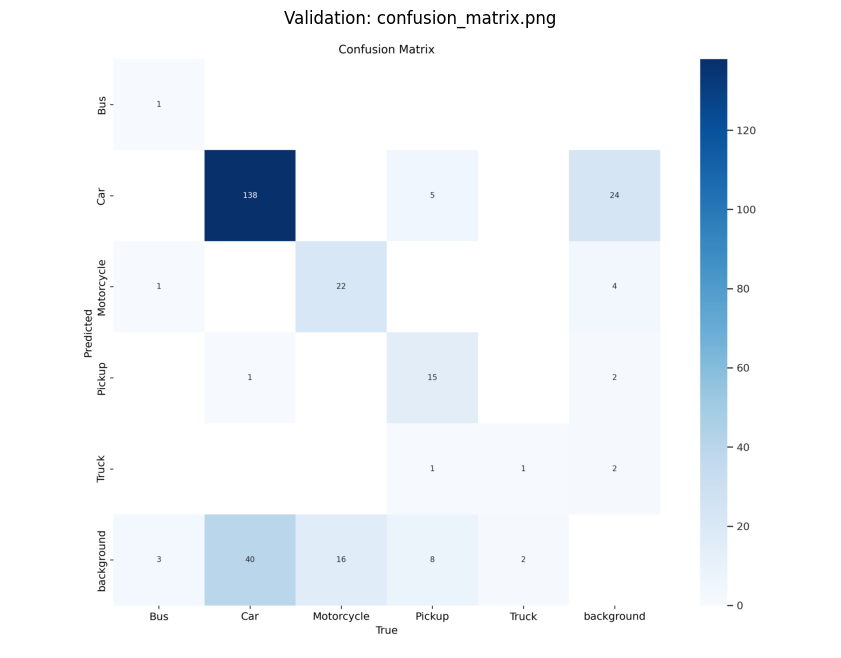

Validation: results.png not found.


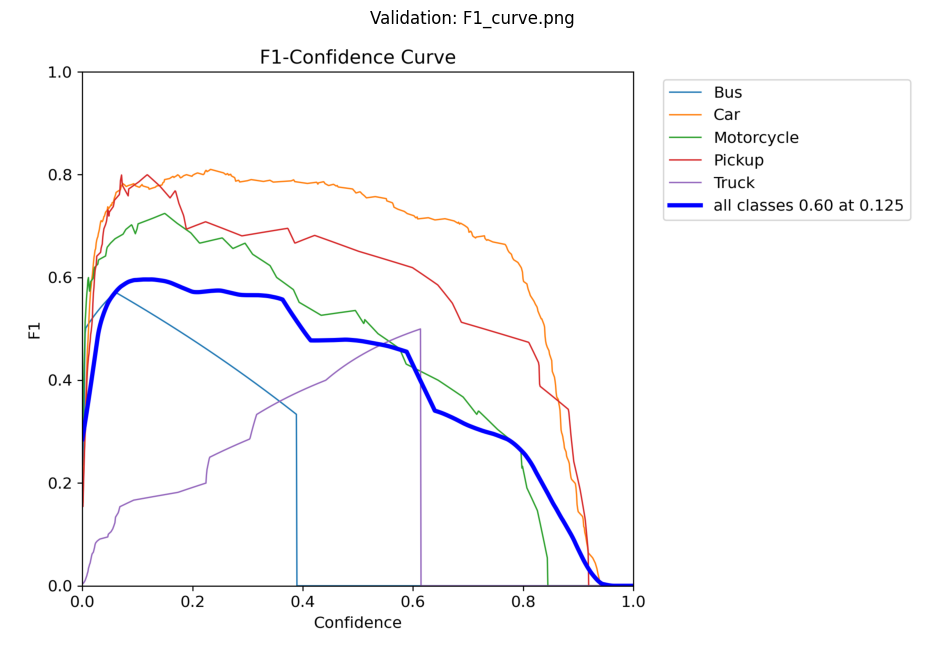

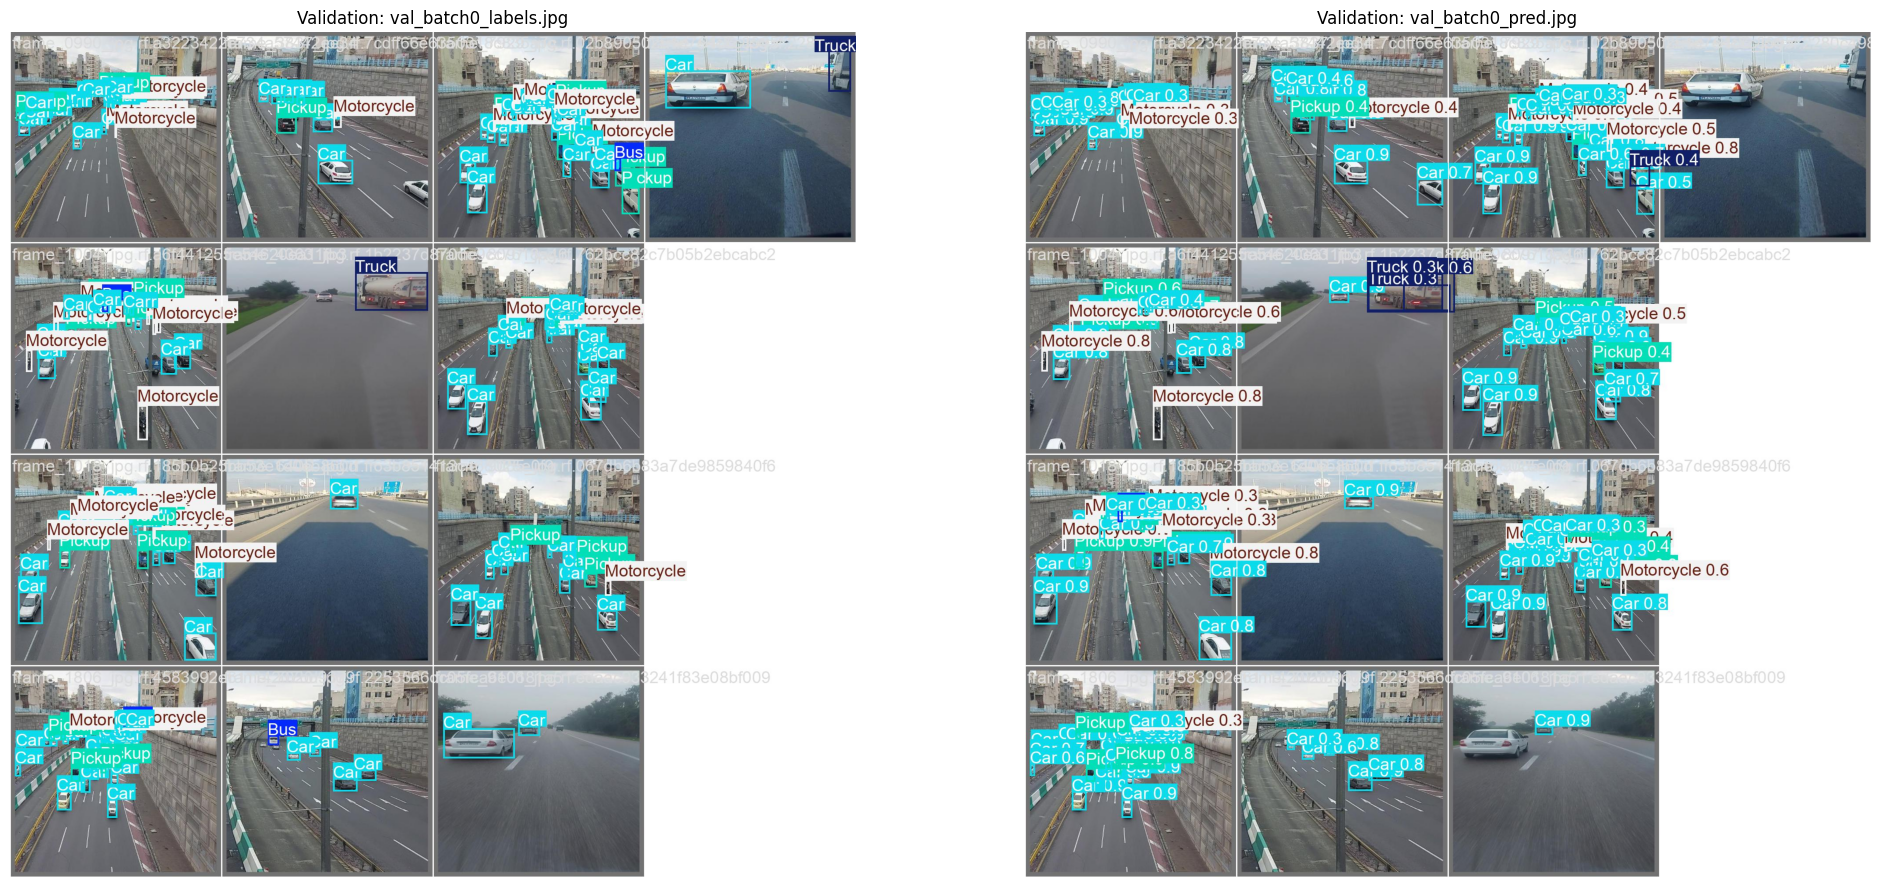

In [14]:
runs_folder = '/content/runs/detect/'

# Find all possible validation folders
val_folders = [f for f in os.listdir(runs_folder) if f.startswith('val') and os.path.isdir(os.path.join(runs_folder, f))]
val_folders.sort(key=lambda x: int(x[3:]) if x[3:].isdigit() else 0)  # Sort by val number or default to 0 for "val"

# Use the latest validation folder if multiple are present
latest_val_folder = val_folders[-1] if val_folders else None
val_folder = os.path.join(runs_folder, latest_val_folder) if latest_val_folder else None

if val_folder:
    # Key image files to display for validation
    key_images_val = [
        'confusion_matrix.png',
        'results.png',
        'F1_curve.png',
        'val_batch0_labels.jpg',
        'val_batch0_pred.jpg'
    ]

    # Display the first three images individually for validation
    for img_file in key_images_val[:3]:
        img_path = os.path.join(val_folder, img_file)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.figure(figsize=(12, 8))
            plt.title(f"Validation: {img_file}")
            plt.imshow(img)
            plt.axis('off')  # Turn off axes for better visualization
            plt.show()
        else:
            print(f"Validation: {img_file} not found.")

    # Display val_batch0_labels.jpg and val_batch0_pred.jpg side by side for validation
    val_label_path = os.path.join(val_folder, key_images_val[3])
    val_pred_path = os.path.join(val_folder, key_images_val[4])

    if os.path.exists(val_label_path) and os.path.exists(val_pred_path):
        fig, axes = plt.subplots(1, 2, figsize=(24, 12))


        val_label_img = Image.open(val_label_path)
        axes[0].imshow(val_label_img)
        axes[0].axis('off')
        axes[0].set_title('Validation: val_batch0_labels.jpg')


        val_pred_img = Image.open(val_pred_path)
        axes[1].imshow(val_pred_img)
        axes[1].axis('off')
        axes[1].set_title('Validation: val_batch0_pred.jpg')

        plt.show()
    else:
        print("Either val_batch0_labels.jpg or val_batch0_pred.jpg is missing in the validation directory.")
else:
    print("No validation folders found.")


The confusion matrix shows us that fewer objects are detected as background with this approach. The left diagonal has some boost in numbers.

# Applying Trained Model to Videos
A more realistic scenario where object detection would be applied is camera feeds. Common household cameras like Google Nest and Amazon Blink come with face and object detection features. We wanted to attempt something similar to bring a real-world application to our project.

To simulate a camera feed, our dataset included a video clip in high and low quality resolution. We will run our model on the video feed and look at the output to see how it would perform if there was a camera mounted on a highway.

In [15]:
# Path to the best weights file
best_weights_path = os.path.join(latest_run, 'weights', 'best.pt')

# Load the model with the found best weights
model = YOLO(best_weights_path)

# Path to your MP4 video file
video_path = '/content/drive/MyDrive/dataset/SampleVideo_LowQuality.mp4'

# Run inference on the video
results = model.predict(source=video_path, save=True, conf=0.25) # Adjust conf as needed




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1001) /content/drive/MyDrive/dataset/SampleVideo_LowQuality.mp4: 384x640 15 Cars, 2 Motorcycles, 97.6ms
video 1/1 (frame 2/1001) /content/drive/MyDrive/dataset/SampleVideo_LowQuality.mp4: 384x640 14 Cars, 3 Motorcycles, 1 Pickup, 18.5ms
video 1/1 (frame 3/1001) /content/drive/MyDrive/dataset/SampleVideo_LowQuality.mp4: 384x640 16 Cars, 2 Motorcycles, 18.0ms
video 1/1 (frame 4/1001) /content/drive/MyDrive/dataset/SampleVideo_LowQualit

In [ ]:
# The code below was obtained from ChatGPT to display the video file within Colab
# Unfortunately, the video decode operation crashes the runtime, likely due to high resource consumption
# The AVI file will be featured in our presentation

def get_latest_predict_folder(base_path="/content/runs/detect"):

    predict_folders = glob.glob(os.path.join(base_path, "predict*"))

    if predict_folders:
        return max(predict_folders, key=os.path.getmtime)
    else:
        raise FileNotFoundError("No 'predict' folder found.")

latest_predict_folder = get_latest_predict_folder()


def get_avi_file_in_folder(folder_path):
    avi_files = glob.glob(os.path.join(folder_path, "*.avi"))
    if avi_files:
        return avi_files[0]  # Assume there's only one .avi file
    else:
        raise FileNotFoundError("No .avi file found in the folder.")

avi_file_path = get_avi_file_in_folder(latest_predict_folder)


mp4_output_path = os.path.splitext(avi_file_path)[0] + ".mp4"


subprocess.run(["ffmpeg", "-i", avi_file_path, "-c:v", "libx264", mp4_output_path], check=True)

def display_video(video_path, width=640):
    video = open(video_path, "rb").read()
    video_b64 = b64encode(video).decode()
    return HTML(f"""
        <video width="{width}" controls>
            <source src="data:video/mp4;base64,{video_b64}" type="video/mp4">
        </video>
    """)


display_video(mp4_output_path)
